# Assignment 5. Tools for Machine Learning Workflow

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to @amirsoleix on Telegram*

### Description  
One of the applications that rises frequently in machine learning projects is classification. A sector where intensively uses classification is retrieval on large data banks mostly by using queries on the previously categorized data. For example, indexing in search engines helps fast retrieval of relevant data, or in e-commerce platforms, appropriate categorization and placement of filters is necessary for better user experience. It allows customers to access their relevant goods with ease, making the platform more profitable.  

In this homework, we want to classify the software, games, etc. available on `downloadha.com`. The website started as a modest delivery network for software, but has since evolved into a precious repository for all kinds of applications for different operating systems and platforms.  

### Information  
Complete the information box below.

In [1]:
full_name = 'Hadi Hadavi'
student_id = '99100263'

## 1 Retrieval of Data

Consider a content delivery website. On the user end, when you want to find what you want in such websites, you probably use the search bar or the navigation menu on the top, or alternatively, let Google find you the best matching result using its proprietary indexing (which by the way, usually works better than the website's own search bar!).  

But as a data engineer, the level of detail and comprehensiveness of data matters more as you are looking for insight rather than single matches. It allows you to analyze different aspects of social behavior on different localities and make informed decisions based on that.  

Consider that you are a data analyst for a software team given the task of analyzing market demand for your upcoming product. In this scenario, one of the best ways is to track activity on forums and goto places where people get their software from. This can range from different online stores and websites, to community forums and related social media posts.  

After discussion, you have found that `downloadha.com` is one of the main sources local people use for downloading their software hence you want to analyze the demand for different categories of softwares.

### 1.1 Data Version Control
Since data is constantly changing, logging the current state of the data is a necessity. It is required that we track the changes and act upon them when necessary, and a prerequisite to knowing when changes occur is to be aware of what changes are logged in our systems and what changes are not. One of the tools used for version controlling the data is `DVC`. Read the documents and use it in the process.

In [5]:
import dvc

### 1.2 Crawling

List the information related to each software for the last 1000 softwares listed on the mentioned website. The website uses pagination with 10 results available on each page. So for reaching 1000 softwares you need to crawl `downloadha.com/page/1/` up to `downloadha.com/page/100/`. For having a safety threshold in case of crawler failure (a common problem in crawlers), you can extend it to 2000 items to be sure you are left with 1000 decent instances.  

This website is chosen in particular for its easy access to database. Remember that as systems gets more advanced accessing older data becomes harder. For comparison try to search for books that were listed on Amazon before 2020 and look at the URL!  

The data for each software should include:
- Name
- Platform
- Category and Subcategories
- Description
- Date of Creation
- Author
- Visit Count
- Comment Count
- Tags

Save the data on a CSV file and upload it with your delivery. You can use libraries like Beautiful Soup and Scrapy for the crawling task.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# Customized functions
def extract_game_info(url):
    """
    Extracts the game name and platform from the given URL.

    Parameters:
        url (str): The URL containing game information.

    Returns:
        tuple: A tuple containing the extracted game name and platform.
    """
    match = re.search(r'/game/(.+?)-(\w+)/?$', url)
    if match:
        game_name = match.group(1).replace('-', ' ').title()
        platform = match.group(2).upper()
        return game_name, platform
    else:
        return "Could not extract info", "Unknown"

def extract_author_name(url):
    """
    Extracts the author's name from the given URL.

    Parameters:
        url (str): The URL containing author information.

    Returns:
        str: The extracted author's name.
    """
    if not url.startswith('https://www.downloadha.com/author/'):
        return "Invalid URL format for author extraction."

    parts = url.rstrip('/').split('/')
    author_name = parts[-1]
    return author_name

def extract_numeric_value(text):
    """
    Extracts numeric values from a text, including commas.

    Parameters:
        text (str): The text containing numeric values.

    Returns:
        int: The extracted numeric value.
    """
    match = re.search(r'[\d,]+', text)
    if match:
        numeric_part = match.group().replace(',', '')
        return int(numeric_part)
    else:
        return None

def convert_to_english_numbers(persian_number):
    """
    Converts Persian numerals to English numerals.

    Parameters:
        persian_number (str): The Persian numeral.

    Returns:
        str: The converted English numeral.
    """
    persian_numerals = '۰۱۲۳۴۵۶۷۸۹'
    english_numerals = '0123456789'
    translation_table = str.maketrans(persian_numerals, english_numerals)
    return persian_number.translate(translation_table)

def extract_comment_count(text):
    """
    Extracts the comment count from a text, handling Persian numbers.

    Parameters:
        text (str): The text containing comment count information.

    Returns:
        int: The extracted comment count.
    """
    if 'بدون نظر' in text:
        return 0
    else:
        match = re.search(r'[\d۰۱۲۳۴۵۶۷۸۹]+', text)
        if match:
            persian_number = match.group()
            return int(convert_to_english_numbers(persian_number))
        else:
            return None

def extract_tags(text):
    """
    Extracts tags from a text.

    Parameters:
        text (str): The text containing tag information.

    Returns:
        list: A list of extracted tags.
    """
    clean_text = text.replace('برچسب ها:', '').replace('برچسب‌ها:', '').strip()
    tags = clean_text.split(', ')
    return tags

def get_article_data(article):
    """
    Extracts data from a given article and returns a dictionary containing relevant information.

    Parameters:
        article (BeautifulSoup): The BeautifulSoup object representing an article.

    Returns:
        dict: Dictionary containing extracted data.
    """
    # Extract title and URL
    title_element = article.find('h2', class_="entry-title")
    url = title_element.find('a')['href'] if title_element and title_element.find('a') else "URL not found"
    name, platform = extract_game_info(url)

    # Extract categories
    dirty_categories = article.find_all('a', rel="category tag")
    categories = [category.get_text() for category in dirty_categories if category]

    # Extract description
    description_element = article.find('p', style='text-align: justify;')
    description = description_element.text if description_element else "Description not available"

    # Extract metadata from the article footer
    footer = article.find('footer')
    if footer:
        # Extract publication time
        time_element = footer.find('time', class_='entry-date published')
        time = time_element.text if time_element else "Time not available"

        # Extract author information
        author_url_element = footer.find('a', class_='url fn n')
        author_url = author_url_element['href'] if author_url_element else "Author URL not found"
        author = extract_author_name(author_url)

        # Extract visit count
        visit_count_element = footer.find('div', class_='post-view inline-block')
        visit_count_dirty = visit_count_element.text if visit_count_element else "0"
        visit_count = extract_numeric_value(visit_count_dirty)

        # Extract comment count
        comment_count_elements = footer.find_all('div', class_='post-view inline-block')
        comment_count_dirty = comment_count_elements[1].text if len(comment_count_elements) > 1 else "0"
        comment_count = extract_comment_count(comment_count_dirty)

        # Extract tags
        tags_dirty = footer.find('div', class_="post-tags")
        tags = extract_tags(tags_dirty.text) if tags_dirty else []

    return {
        'Title': name,
        'Platform': platform,
        'Categories': categories,
        'Description': description,
        'Publication Time': time,
        'Author': author,
        'Visit Count': visit_count,
        'Comment Count': comment_count,
        'Tags': tags
    }

# Main code
all_articles = []

for page_number in range(1, 400):
    url = f"https://www.downloadha.com/page/{page_number}/"
    response = requests.get(url)
    response_content = response.content
    soup = BeautifulSoup(response_content, 'html.parser')
    main = soup.find('main')
    articles = main.find_all('article')

    for article in articles:
        # Extract data for each article and append to the list
        article_data = get_article_data(article)
        all_articles.append(article_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_articles)

# Define the CSV file name
csv_file = "software_data.csv"

# Write to CSV
df.to_csv(csv_file, index=False, encoding='utf-8')
print(f"Data written to {csv_file}")

# Display the shape of the DataFrame
df_shape = df.shape
print(f"DataFrame shape: {df_shape}")


### 1.3 Database (Bonus)  
Use a relational database like MySQL, SQLite or a non-relational instance like MongoDB for archiving the data. You don't need online implementation of this and can create a local instance of database and upload the relevant files with your delivery.

In [2]:
import sqlite3
import pandas as pd

def convert_list_to_string(column):
    """
    Convert lists in a DataFrame column to strings.

    Parameters:
        column (pd.Series): DataFrame column containing lists.

    Returns:
        pd.Series: Updated DataFrame column with lists converted to strings.
    """
    return column.apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('games_data.db')
cursor = conn.cursor()

# Create a table in the database
cursor.execute('''
    CREATE TABLE IF NOT EXISTS games (
        Title TEXT,
        Platform TEXT,
        Categories TEXT,
        Description TEXT,
        PublicationTime TEXT,
        Author TEXT,
        VisitCount INTEGER,
        CommentCount INTEGER,
        Tags TEXT
    )
''')
conn.commit()

df = pd.read_csv("software_data.csv")

# Convert 'Categories' and 'Tags' columns using the new functions
df['Categories'] = convert_list_to_string(df['Categories'])
df['Tags'] = convert_list_to_string(df['Tags'])

# Convert all columns to strings before writing to SQLite database
df = df.astype(str)

# Write data to SQLite database using the new functions
df.to_sql('games', conn, if_exists='replace', index=False)

# Example: Select all records
cursor.execute('SELECT * FROM games')
rows = cursor.fetchall()

for row in rows:
    print(row)

conn.close()

('The Talos Principle', '2', "['بازی کامپیوتر', 'بازی ماجرایی', 'پلتفرمر', 'معمایی']", 'بازی The Talos Principle 2 از همان ابتدا به شما نشان می\u200cدهد که دنیای جدیدی پیرامون\u200cتان قرار دارد. بشریت در این دنیا منقرض شده است، اما فرهنگ بشری هنوز هم در شهر ربات\u200cها جریان دارد. کاراکتر بازی خودش را درگیر ماجراجویی\u200cهای هیجان انگیز کرده و قصد دارد که یک ابرساختار مرموز را شکل دهد که قدرت\u200cهای عظیم جهان را به خود جلب می\u200cکند. با کشف المان\u200cهای بیشتر در دنیای بازی، سوالات بیشتری در مورد دنیا خواهید داشت. باید ماهیت کیهان و هدف تمدن را متوجه شوید. شاید فردایی بهتر در انتظار بشریت باشد.', '۱۴۰۲/۱۱/۰۹', 'behnam', '9905', '4.0', "['بازی AAA', 'دانلود The Talos Principle 2', 'دانلود بازی The Talos Principle 2', 'دانلود بازی The Talos Principle 2 برای کامپیوتر', 'دانلود بازی The Talos Principle 2 کرک شده', 'دانلود بازی کامپیوتر The Talos Principle 2']")
('Against The', 'STORM', "['بازی استراتژیک', 'بازی کامپیوتر', 'شبیه سازی']", 'در بازی Against the Storm در نقش نایب السلطن

## 2 Exploratory Data Analysis

Report the information about the data in charts. This includes converting the data into a consistent format, including the dates, descriptions, etc.  

More attention needs to be put toward the default categorization the website has provided. As it is given in a breadcrumb format, you need to breakdown the category to extract different levels. You need to deliver the following data/visualizations for this part:

- Graph of different categories and subcategories of the softwares available on the website. Some of the material listed might not be software but videos. For those, use the default category of the website to create a new section. **Treat videos, educational packages, etc. just as other categories of software. Do not exclude them from the data.**

C:\Users\Hadi\AppData\Local\Temp\ipykernel_7688\368572032.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=translated_category_counts.values, y=translated_category_counts.index, palette='viridis')


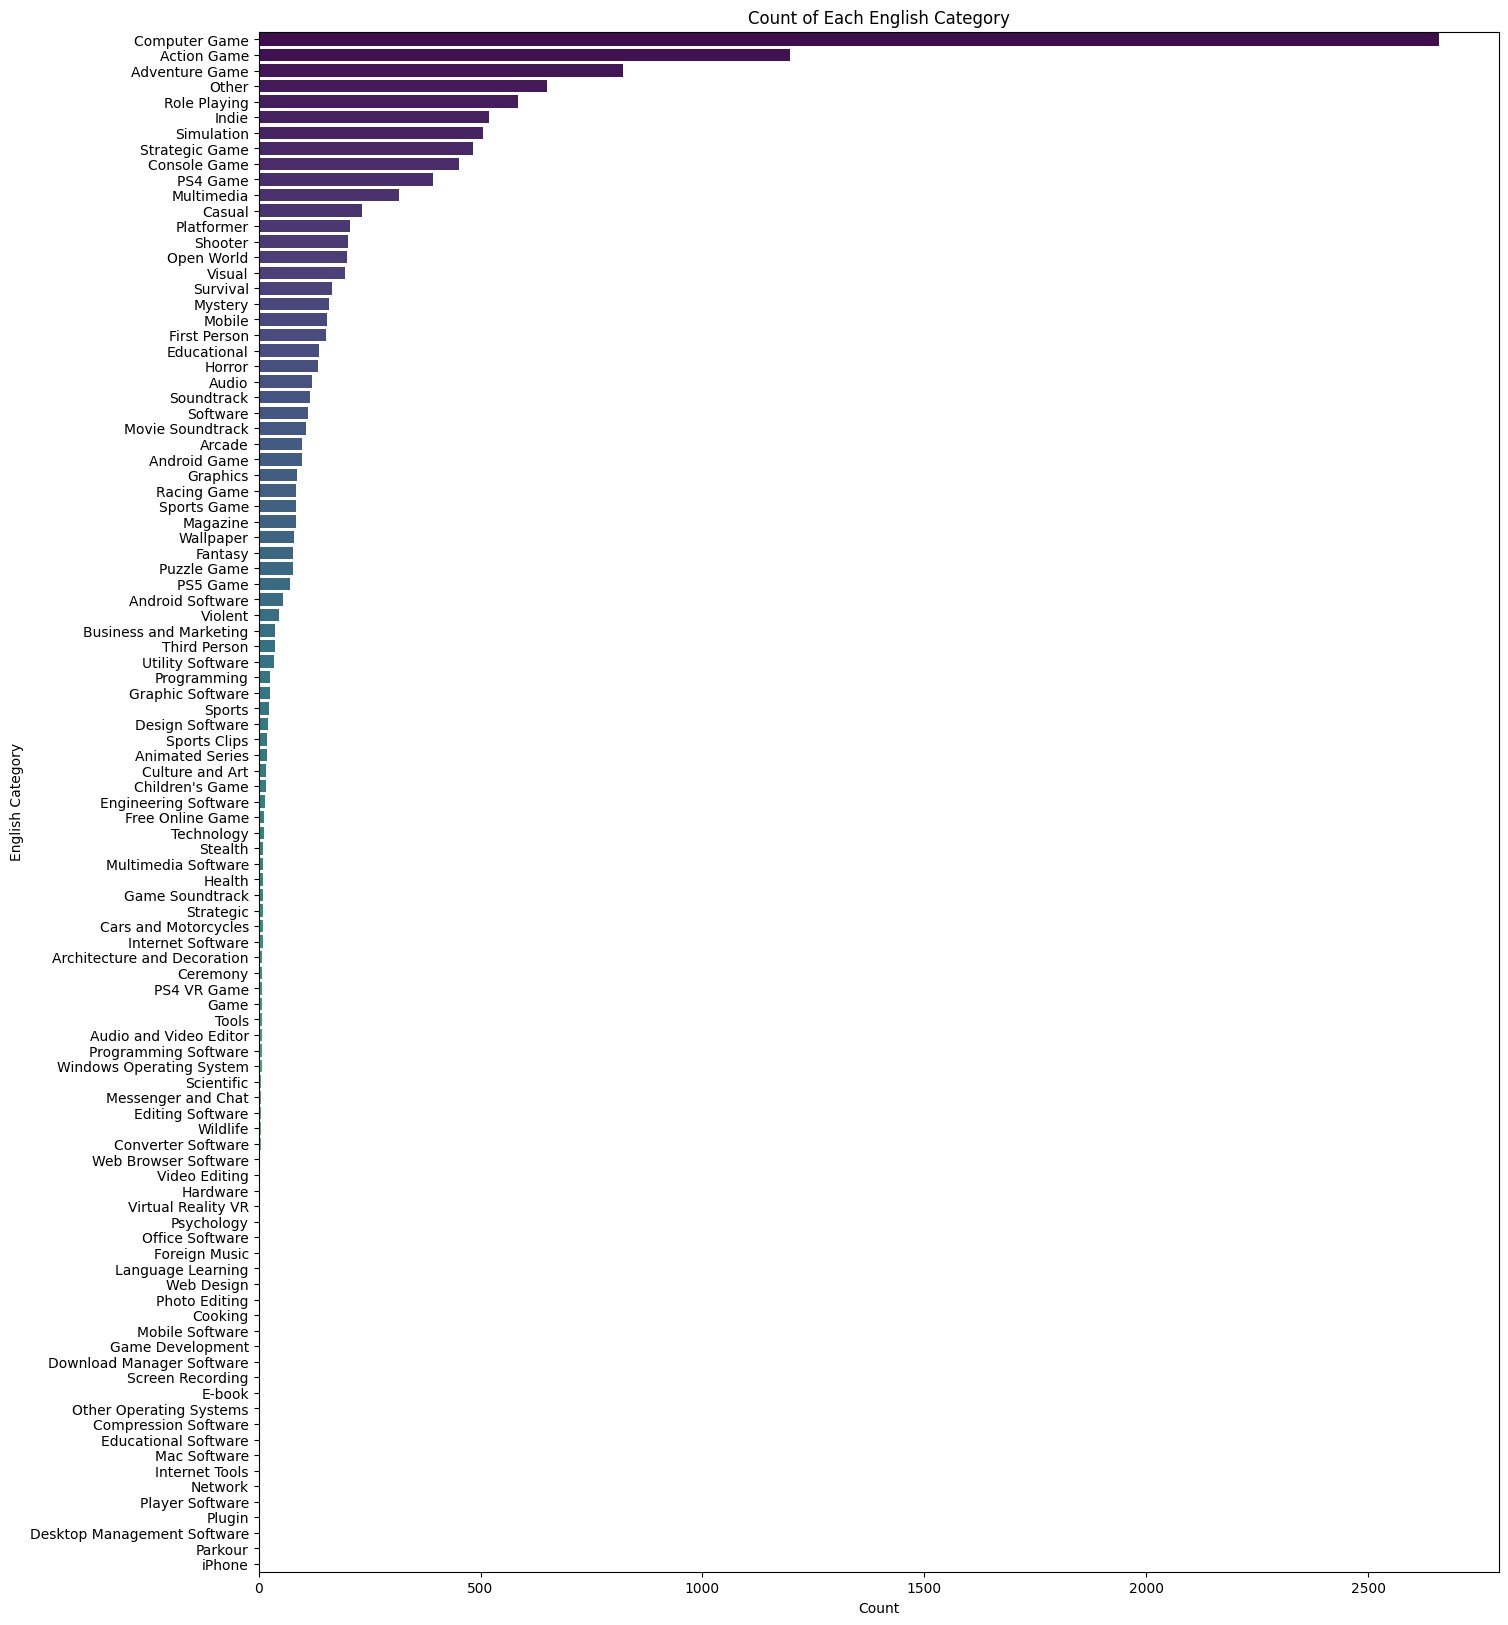

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already read the CSV file into df
df = pd.read_csv("software_data.csv")

# Make a copy of the dataframe to avoid modifying the original data
data = df.copy()

# Translation of Persian categories into English
category_translation = {
    'آرکید': 'Arcade',
    'آشپزی': 'Cooking',
    'آموزش زبان': 'Language Learning',
    'آموزشی': 'Educational',
    'آیفون': 'iPhone',
    'ابزار اینترنت': 'Internet Tools',
    'ابزارها': 'Tools',
    'استراتژیک': 'Strategic',
    'انیمیشن سریالی': 'Animated Series',
    'اول شخص': 'First Person',
    'ایندی': 'Indie',
    'بازی': 'Game',
    'بازی PS4': 'PS4 Game',
    'بازی PS4 VR': 'PS4 VR Game',
    'بازی PS5': 'PS5 Game',
    'بازی آنلاین رایگان': 'Free Online Game',
    'بازی استراتژیک': 'Strategic Game',
    'بازی اندروید': 'Android Game',
    'بازی اکشن': 'Action Game',
    'بازی فکری': 'Puzzle Game',
    'بازی ماجرایی': 'Adventure Game',
    'بازی ماشین سواری': 'Racing Game',
    'بازی ورزشی': 'Sports Game',
    'بازی کامپیوتر': 'Computer Game',
    'بازی کنسول': 'Console Game',
    'بازی کودکان': 'Children\'s Game',
    'برنامه نویسی': 'Programming',
    'تجارت و بازاریابی': 'Business and Marketing',
    'ترسناک': 'Horror',
    'تصویری': 'Visual',
    'تلاش برای بقا': 'Survival',
    'تکنولوژی': 'Technology',
    'جهان آزاد': 'Open World',
    'حیات وحش': 'Wildlife',
    'خشونت آمیز': 'Violent',
    'خودرو و موتور': 'Cars and Motorcycles',
    'روانشناسی': 'Psychology',
    'ساخت بازی': 'Game Development',
    'سایر': 'Other',
    'سایر سیستم عامل ها': 'Other Operating Systems',
    'سخت افزار': 'Hardware',
    'سلامت': 'Health',
    'سوم شخص': 'Third Person',
    'سیستم عامل ویندوز': 'Windows Operating System',
    'شبکه': 'Network',
    'شبیه سازی': 'Simulation',
    'شوتر': 'Shooter',
    'صوتی': 'Audio',
    'ضبط صفحه نمایش': 'Screen Recording',
    'طراحی وب': 'Web Design',
    'علمی': 'Scientific',
    'فانتزی': 'Fantasy',
    'فرهنگ و هنر': 'Culture and Art',
    'مالتی مدیا': 'Multimedia',
    'مجله': 'Magazine',
    'مخفی کاری': 'Stealth',
    'مراسم': 'Ceremony',
    'مسنجر و پیغام رسان': 'Messenger and Chat',
    'معماری و دکوراسیون': 'Architecture and Decoration',
    'معمایی': 'Mystery',
    'موبایل': 'Mobile',
    'موزیک خارجی': 'Foreign Music',
    'موسیقی متن': 'Soundtrack',
    'موسیقی متن بازی': 'Game Soundtrack',
    'موسیقی متن فیلم': 'Movie Soundtrack',
    'نرم افزار': 'Software',
    'نرم افزار آفیس': 'Office Software',
    'نرم افزار آموزشی': 'Educational Software',
    'نرم افزار اندروید': 'Android Software',
    'نرم افزار اینترنت': 'Internet Software',
    'نرم افزار برنامه نویسی': 'Programming Software',
    'نرم افزار تبدیل کننده': 'Converter Software',
    'نرم افزار طراحی': 'Design Software',
    'نرم افزار فشرده ساز': 'Compression Software',
    'نرم افزار مالتی مدیا': 'Multimedia Software',
    'نرم افزار مبدل': 'Converter Software',
    'نرم افزار مدیریت دانلود': 'Download Manager Software',
    'نرم افزار مدیریت دسکتاپ': 'Desktop Management Software',
    'نرم افزار مرورگر وب': 'Web Browser Software',
    'نرم افزار مهندسی': 'Engineering Software',
    'نرم افزار موبایل': 'Mobile Software',
    'نرم افزار ویرایشگر': 'Editing Software',
    'نرم افزار پخش کننده': 'Player Software',
    'نرم افزار کاربردی': 'Utility Software',
    'نرم افزار گرافیک': 'Graphic Software',
    'نرم افزارهای مک': 'Mac Software',
    'نقش آفرینی': 'Role Playing',
    'واقعیت مجازی VR': 'Virtual Reality VR',
    'والپیپر': 'Wallpaper',
    'ورزشی': 'Sports',
    'ویرایش عکس': 'Photo Editing',
    'ویرایش فیلم': 'Video Editing',
    'ویرایشگر صوت و تصویر': 'Audio and Video Editor',
    'پارکور': 'Parkour',
    'پلاگین': 'Plugin',
    'پلتفرمر': 'Platformer',
    'کتاب الکترونیک': 'E-book',
    'کلیپ های ورزشی': 'Sports Clips',
    'کژوال': 'Casual',
    'گرافیک': 'Graphics'
}

# Split the 'Categories' column into a list of categories
df['Categories'] = df['Categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# Function to clean and translate Persian categories to English
def clean_and_translate_category(persian_categories):
    if isinstance(persian_categories, list):
        cleaned_categories = [cat.strip("[]'") for cat in persian_categories]
        return [category_translation.get(cat, 'Other') for cat in cleaned_categories]
    else:
        cleaned_category = persian_categories.strip("[]'")
        return category_translation.get(cleaned_category, 'Other')

# Apply the translation function to each element in the 'Categories' column
df['TranslatedCategories'] = df['Categories'].apply(clean_and_translate_category)

# Flatten the list of translated categories and count their occurrences
translated_category_counts = pd.Series([item for sublist in df['TranslatedCategories'].dropna() for item in sublist]).value_counts()

# Plot the count of each English category over the entire dataset
plt.figure(figsize=(16, 20))
sns.barplot(x=translated_category_counts.values, y=translated_category_counts.index, palette='viridis')
plt.title('Count of Each English Category')
plt.xlabel('Count')
plt.ylabel('English Category')
plt.show()


- Frequency of softwares provided for different platforms and operating systems including but not limited to PS5, Windows, Linux, MacOS X.

C:\Users\Hadi\AppData\Local\Temp\ipykernel_7688\2710434788.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_counts.values, y=platform_counts.index, palette=palette)


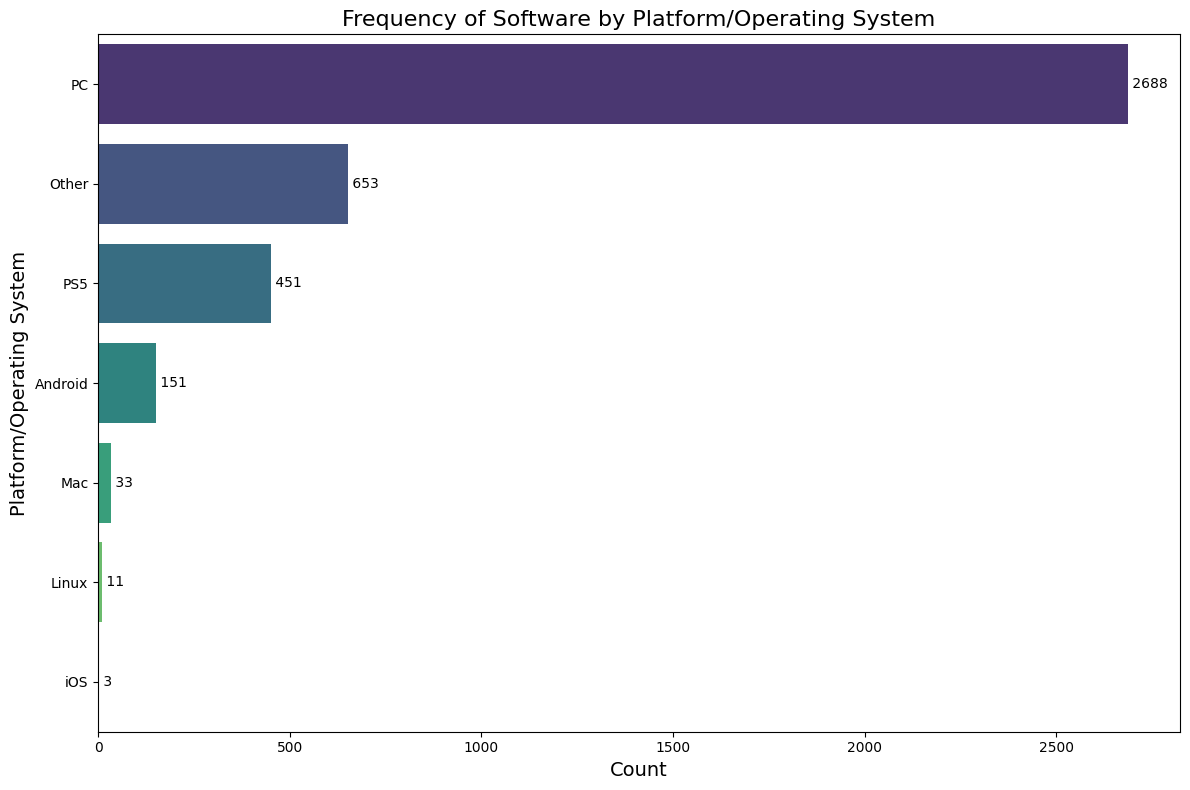

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already read the CSV file into df
df = pd.read_csv("software_data.csv")

# Make a copy of the dataframe to avoid modifying the original data
data = df.copy()

# Define platform keywords
platform_keywords = {
    'PC': ['Computer Game', 'Compression Software', 'Game Development', 'Programming'],
    'iOS': ['iPhone', 'Mobile Software'],
    'PS5': ['PS5 Game', 'Console Game'],
    'Android': ['Android Game', 'Android Software'],
    'Mac': ['Mac Software', 'MacOS', 'Design Software', 'Multimedia Software'],
    'Linux': ['Linux', 'Programming', 'Engineering Software'],
}

# Function to determine the platform based on categories
def determine_platform(categories):
    if isinstance(categories, list):
        categories = [category_translation.get(cat, 'Other') for cat in categories]
    elif isinstance(categories, str):
        categories = [category_translation.get(cat.strip("[]'"), 'Other') for cat in eval(categories)]
    else:
        return 'Other'  # Default value if no categories are provided
    
    for platform, keywords in platform_keywords.items():
        if any(keyword in categories for keyword in keywords):
            return platform
    return 'Other'  # Default value if no platform-specific keyword is found

# Apply the determine_platform function to each element in the 'Categories' column
df['Platform'] = df['Categories'].apply(determine_platform)

# Count the frequency of each platform
platform_counts = df['Platform'].value_counts()

# Plot the frequency of software by platform/operating system
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(platform_counts))
sns.barplot(x=platform_counts.values, y=platform_counts.index, palette=palette)
for i, value in enumerate(platform_counts.values):
    plt.text(value, i, f' {value}', va='center')
plt.title('Frequency of Software by Platform/Operating System', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Platform/Operating System', fontsize=14)
plt.tight_layout()
plt.show()


## 3 Classification Beyond the Website

Now its time to extract the insights we need. For this part, you are free to use whichever technique, algorithm and library you desire. Just remember that the notebook should be able to provide the result locally, so avoid using online systems. Deliver the following items:

- Classify different categories of software and identify the top 5 hottest software categories and subcategories on the website based on the number of reviews and visits of softwares in that category. Explain your process and reasoning along with your results.

In [33]:
# Drop rows with missing values in 'Comment Count', 'Visit Count', and 'Categories'
df = df.dropna(subset=['Comment Count', 'Visit Count', 'Categories'])

# Convert the 'Categories' column from string representation to actual lists
df['Categories'] = df['Categories'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Define a scoring function for each software item
df['Score'] = df['Visit Count'] + 100 * df['Comment Count']

# Initialize a dictionary to store the category scores
category_scores = {}

# Iterate over rows and calculate category scores
for index, row in df.iterrows():
    for category in row['Categories']:
        category_scores[category] = category_scores.get(category, 0) + row['Score']

# Create a DataFrame from the category scores
category_scores_df = pd.DataFrame(list(category_scores.items()), columns=['Category', 'Total Score'])

# Sort the categories based on total score in descending order
category_scores_df = category_scores_df.sort_values(by='Total Score', ascending=False)

# Print the top 5 hottest software categories based on total score
print("\nTop 5 Hottest Software Categories:")
print(category_scores_df.head(5))



Top 5 Hottest Software Categories:
         Category  Total Score
0   بازی کامپیوتر   43425666.0
6       بازی اکشن   28381996.0
1    بازی ماجرایی   15250288.0
14      جهان آزاد   10536148.0
8      نقش آفرینی    9376386.0


- Your team wants to contact the admins of the website directly. Using the `author` field you gathered previously, find out which individuals are responsible for posting softwares of different categories. This is done by matching the authors with categories and finding out the `author`s most responsible for the latest posts in different categories. As an example, you may find that 70 percent of PS5 action games are posted by **John Doe**, so it is probable that this individual is tasked with finding out the latest games of PS5 and posting them on the website.

In [35]:
import pandas as pd
import jdatetime

# Removing the invalid dates
persian_digits = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']
df = df[df['Publication Time'].apply(lambda x: str(x).startswith(tuple(persian_digits)))]

# Converting the Publication Time column to a datetime column
def convert_persian_date(date):
    persian_digits2 = {
        '۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
        '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'
    }
    western_date = ''.join(persian_digits2.get(ch, ch) for ch in date)
    year, month, day = map(int, western_date.split('/'))
    gregorian_date = jdatetime.date(year, month, day).togregorian()
    return gregorian_date

df['Publication Time1'] = df['Publication Time'].apply(convert_persian_date)
df.drop('Publication Time', axis=1, inplace=True)
df.rename(columns={'Publication Time1': 'Publication Time'}, inplace=True)

# Finding the top authors for recent posts
# We will consider the posts since 2023
df['Publication Time'] = pd.to_datetime(df['Publication Time'])
df_recent = df[df['Publication Time'].dt.year >= 2023]

rows = []
for _, row in df_recent.iterrows():
    for category in row['Categories']:
        rows.append({
            'Author': row['Author'],
            'Category': category,
        })

expanded_data = pd.DataFrame(rows)

# Group by Categories and Authors
grouped_data = expanded_data.groupby(['Category', 'Author']).size().reset_index(name='Post Count')

# Finding the top authors for each category
top_authors_per_category = grouped_data.sort_values('Post Count', ascending=False).groupby('Category').head(1)
top_authors_per_category.reset_index(drop=True, inplace=True)

print(top_authors_per_category)


                   Category  Author  Post Count
0             بازی کامپیوتر  behnam         992
1                 بازی اکشن  behnam         421
2              بازی ماجرایی  behnam         281
3                نقش آفرینی  behnam         236
4                 شبیه سازی  behnam         196
..                      ...     ...         ...
73         نرم افزار مهندسی  hosein           1
74  نرم افزار مدیریت دانلود  hosein           1
75           نرم افزار مبدل   admin           1
76           نرم افزار آفیس  behnam           1
77        نرم افزار اینترنت  hosein           1

[78 rows x 3 columns]


- Find out and list five the sources you think the softwares and videos of the website are gathered from. Since `downloadha.com` is not a producer nor a developer, its objective is gathering different softwares from different vendors in one place. And it is most likely that it uses other websites as its source. Using the descriptions and analyzing it for entity names, it is possible to extract useful information about its possible sources. Explain your approach comprehensively and present your results.